In [303]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import supervisedml as sml

# Unsupervised learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import pickle
import gc

# Step 1: Load data

We start by loading in the data and just take a quick peek at the first few rows and the shape of the data to see that the data is correctly loaded.

In [304]:
df = pd.read_excel(".\\Data\\WA_Fn-UseC_-HR-Employee-Attrition.xlsx")

In [305]:
df.shape

(1470, 35)

In [306]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Step 2: Clean data

After loading the data, we will start by looking for missing values, and then we will look at the data types of the columns to see if they are correctly assigned. We will also look at the unique values of the columns to see if there are any inconsistencies in the data.

In [307]:
print("--- Check for missing values ---")
print(df.isnull().sum())

print("--- Check for NaN values ---")
print(df.isna().sum())

print("--- Check for data types ---")
print(df.info())

--- Check for missing values ---
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsIn

No null or nan values are found, but there is seen a lot of 'object' types in the data set. This is most likely all strings, which is difficult for a machine learning model to work with. First order of operations will be to check if any of them contains only a singular value.

In [308]:
print(df["Attrition"].unique())
print(df["BusinessTravel"].unique())
print(df["Department"].unique())
print(df["EducationField"].unique())
print(df["Gender"].unique())
print(df["JobRole"].unique())
print(df["MaritalStatus"].unique())
print(df["Over18"].unique())
print(df["OverTime"].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research & Development' 'Human Resources']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
['Female' 'Male']
['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
['Single' 'Married' 'Divorced']
['Y']
['Yes' 'No']


For good measure, a few other values were also tested. It was found that the employee count and the standard hours were all the same, so they should be dropped along with 'Over18' as it contains only a single value. Employee number will also be removed as it is only an identifier and not a measurable data point.

In [309]:
cleaned_df = df.drop(["Over18"], axis=1) # All values are "Y"
cleaned_df = cleaned_df.drop(["EmployeeNumber"], axis=1) # All values are unique
cleaned_df = cleaned_df.drop(["EmployeeCount"], axis=1) # All values are 1
cleaned_df = cleaned_df.drop(["StandardHours"], axis=1) # All values are 80

The rest of the strings are then "one-hot encoded" using pandas get_dummies method. This leaves a redundant field in 'Attrition_No', since the data is only interested in knowing if an employee is not at the company.

In [310]:
cleaned_df = pd.get_dummies(cleaned_df, columns=['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'], dtype=pd.Int64Dtype())
cleaned_df = cleaned_df.drop(["Attrition_No"], axis=1) # Redundant
cleaned_df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,0,1,0,0,0,1,0,1,0
2,37,1373,2,2,4,92,2,1,3,2090,...,0,0,0,0,0,0,0,1,0,1
3,33,1392,3,4,4,56,3,1,3,2909,...,0,0,1,0,0,0,1,0,0,1
4,27,591,2,1,1,40,3,1,2,3468,...,0,0,0,0,0,0,1,0,1,0


# Step 3: Explore data

In [311]:
# - Which work positions and departments are in higher risk of losing employees?

# Group by each column (except 'Attrition') and calculate the percentages
percentages = {}
for col in df.columns:
    if col == 'JobRole' or col == 'Department':
        grouped = df.groupby([col, 'Attrition']).size().unstack(fill_value=0)
        total_counts = grouped.sum(axis=1)
        percentages[col] = grouped.apply(lambda x: f"{x['Yes']}/{total_counts[x.name]} ({100 * x['Yes'] / total_counts[x.name]:.2f}%)", axis=1)

# Print the results
for col, percentage in percentages.items():
    print(f"{col}:")
    print(percentage)
    print()


SyntaxError: f-string: unmatched '[' (3512675915.py, line 9)

In [ ]:
# - Are employees of different gender paid equally in all departments?


In [ ]:
# - Do the family status and the distance from work influence the work-life balance?


In [ ]:
# - Does education make people happy (satisfied from the work)?


As one of the end goals is to predict the chance of a certain employee leaving, then looking for any correlation with that will help with specifying important features.

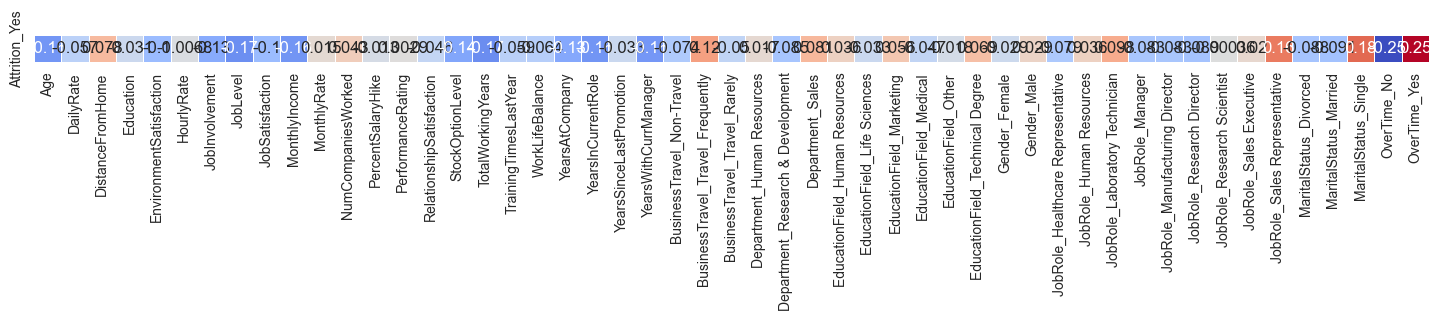

Attrition_Yes                        1.000000
OverTime_Yes                         0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
EducationField_Human Resources       0.036466
JobRole_Human Resources              0.036215
Gender_Male                          0.029453
JobRole_Sales Executive              0.019774
Department_Human Resources           0.016832
MonthlyRate                          0.015170
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.006846
PercentSalaryHike                   -0.013478
EducationField_Other              

In [ ]:
df_corr = cleaned_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(df_corr['Attrition_Yes'].drop('Attrition_Yes').to_frame().T, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False, square=True)
plt.show()

# Using the absolute value of the correlation, we can find the attribute that is closest to zero
df_attrition_yes_corr = df_corr['Attrition_Yes'].sort_values(ascending=False)
print(df_attrition_yes_corr)

closest_to_zero = df_attrition_yes_corr.abs().idxmin()
print(f"\nClosest to zero: {closest_to_zero}")

Since the data set contains a lot of features, a cutting point is set at 5%. This means any feature with less than a 5% correlation is removed. For a smaller feature set, a lower value would be more appropriate, otherwise the data would lose too much data history.

(1470, 52)
(1470, 33)


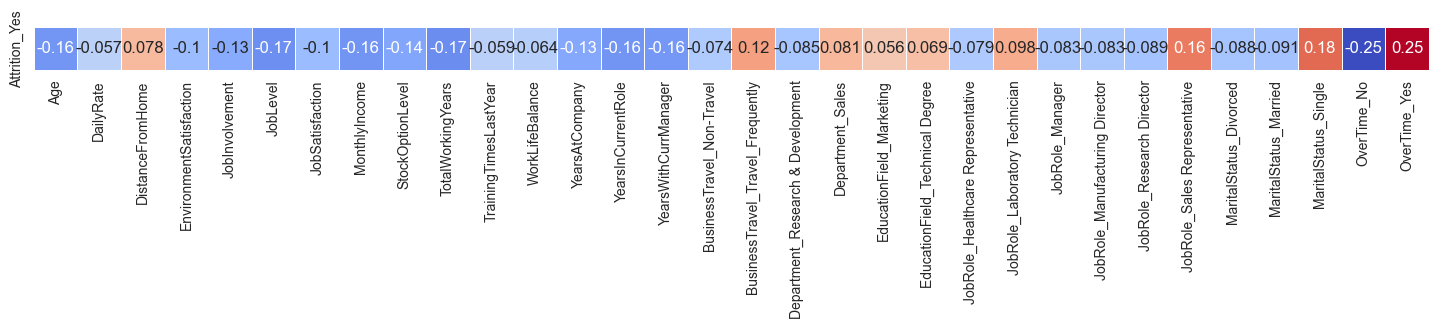

In [ ]:
# Drop all columns that have a correlation of less than 5%
print(cleaned_df.shape)
cleaned_df = cleaned_df.drop(df_attrition_yes_corr[(df_attrition_yes_corr < 0.05) & (df_attrition_yes_corr > -0.05)].index, axis=1)
print(cleaned_df.shape)

df_corr = cleaned_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(df_corr['Attrition_Yes'].drop('Attrition_Yes').to_frame().T, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False, square=True)
plt.show()

This lead to a reduction in 19 features, from 52 to 33.

# Step 4: Supervised machine learning

For making supervised models, a Random Forest, Bernoulli Naïve Bayes and a Voting classifier will be used. A decision tree could also be considered, but if a decision tree can fit the data, then a random forest can fit it even better as it is testing on multiple trees.

In [ ]:
test_size = 0.2
seed = 42

In [ ]:
# Random forest with transformed data
df = cleaned_df.dropna()

# Split the data into features and target
X = df.drop('Attrition_Yes', axis=1)
y = df['Attrition_Yes']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [ ]:
# Random Forest Classifier with transformed data
print("--- Model Checker ---")
print("Random Forest Classifier")
RFCModelChecker = sml.ModelChecker(RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)
RFCModelChecker.run()
RFCModelChecker.show_accuracy()
RFCmodel = RFCModelChecker.model

# Bernoulli Naive Bayes with transformed data
print("\nBernoulli Naive Bayes")
BNBModelChecker = sml.ModelChecker(BernoulliNB(), X_train, y_train, X_test, y_test)
BNBModelChecker.run()
BNBModelChecker.show_accuracy()
BNBmodel = BNBModelChecker.model

# Voting classifier with transformed data, Random Forest and Bernoulli Naive Bayes
print("\nVoting Classifier")
VCModelChecker = sml.ModelChecker(VotingClassifier(estimators=[('rf', RFCmodel), ('nb', BNBmodel)], voting='soft'), X_train, y_train, X_test, y_test)
VCModelChecker.run()
VCModelChecker.show_accuracy()
VCmodel = VCModelChecker.model

--- Model Checker ---
Random Forest Classifier
R2 accuracy score: 0.8707482993197279
Mean squared error: 0.1292517006802721
Root mean squared error: 0.35951592548908334

Bernoulli Naive Bayes
R2 accuracy score: 0.8095238095238095
Mean squared error: 0.19047619047619047
Root mean squared error: 0.4364357804719847

Voting Classifier
R2 accuracy score: 0.8503401360544217
Mean squared error: 0.14965986394557823
Root mean squared error: 0.3868589716493314


The best model seems to be the Random Forest Classifier at 85,5%-88% accuracy even though it has a fairly high error rate, which should be kept in mind when using it.

For saving the model, the "pickling" technich will be applied as it isn't a large model. With a larger model, other technics should be considered as pickling can be a bit slower. In this case it takes less than a second so speed is not a concern.

In [ ]:
# Pickle the model
filename = "bestfit_model.save"
pickle.dump(RFCmodel, open(filename, 'wb'))

# Delete the models to free up memory. They will not be used anymore so there is no need to keep them in memory
del RFCModelChecker
del BNBModelChecker
del VCModelChecker
gc.collect()

22337

Prove that the pickling has gone well:

In [ ]:
# Load the model
loaded_model = pickle.load(open(filename, 'rb'))

# Make predictions on the validation set
y_pred = loaded_model.predict(X_test)

score = loaded_model.score(X_test, y_test)
print(f"Accuracy score: {score}")

Accuracy score: 0.8707482993197279


# Step 5: Unsupervised machine learning

## K Means

The dropped fields create irregularities, which makes clustering almost impossible and are therefor dropped. 

In [ ]:
cluster_df = cleaned_df.drop(["MonthlyIncome", "DailyRate", "YearsAtCompany", "TotalWorkingYears"], axis=1)
X = cluster_df.values

### Finding number of clusters

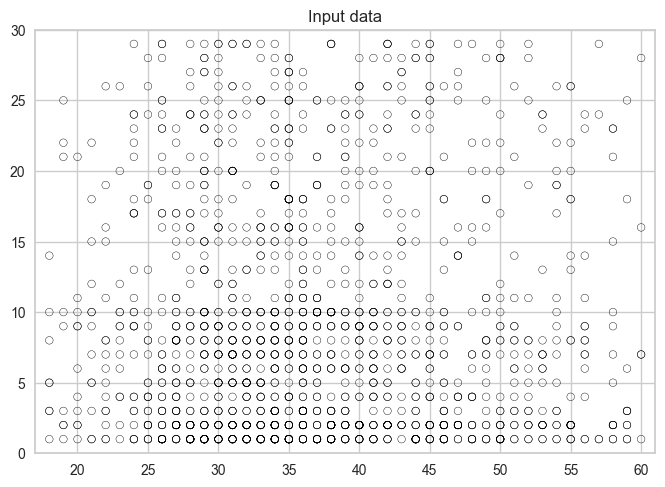

In [ ]:
# Plot the input data
# a. creates figure
plt.figure()
plt.title('Input data')

# b. get the range of X and Y (long way)
# first column
x_min = X[:, 0].min()
x_max = X[:, 0].max()

# second column
y_min = X[:, 1].min()
y_max = X[:, 1].max()

# same as above: get the range of X and Y (short way)
# x_min, x_max = X[:, 0].min(), X[:, 0].max()
# y_min, y_max = X[:, 1].min(), X[:, 1].max()

# c. set plot limits
plt.xlim(x_min - 1, x_max + 1)
plt.ylim(y_min - 1, y_max + 1)

# plot the points
plt.scatter(X[:,0], X[:,1], marker='o', facecolors='none', edgecolors='black', s=30)

plt.show()

Elbow: [271165.0170068028, 186360.54858993905, 129876.17661507767, 111150.44978493768, 94653.61935373812, 84235.41711373521, 79045.96195357732, 74304.70277662735, 69868.5055096868]
SilhouetteScore: [0.2916980116128057, 0.32880930529383995, 0.3040811743772969, 0.25017685542633256, 0.25541025967966274, 0.24422415631455377, 0.2345301186342806, 0.2173114373980135]


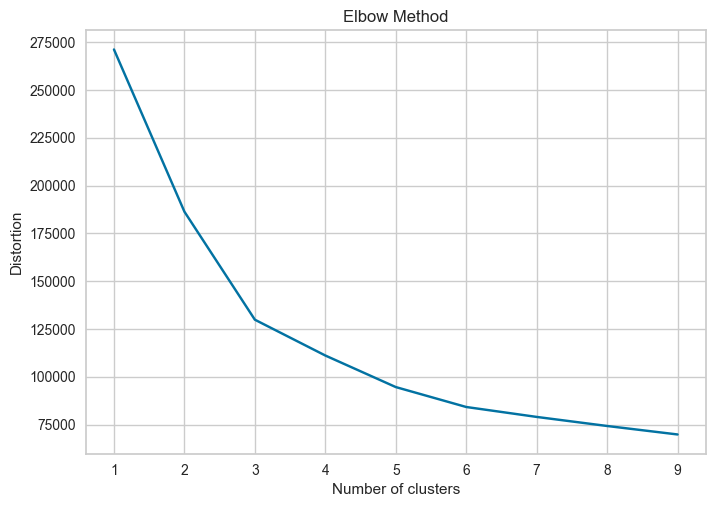

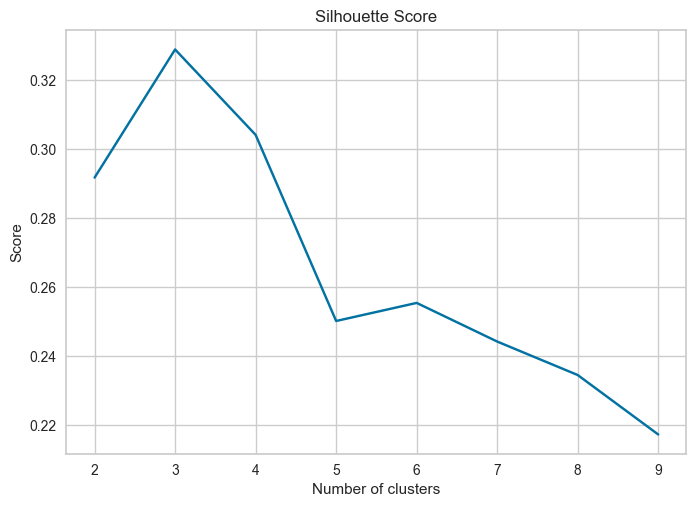

In [ ]:
elbowDistortions = []
scoreDistortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    elbowDistortions.append(kmeans.inertia_)
    if (k != 1):
        score = silhouette_score(X, kmeans.labels_, metric='euclidean', sample_size=len(X))
        scoreDistortions.append(score)

print("Elbow:", elbowDistortions)
print("SilhouetteScore:", scoreDistortions)

plt.figure()
plt.plot(range(1, 10), elbowDistortions)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

plt.figure()
plt.plot(range(2, 10), scoreDistortions)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

Both methods seems to indicate that the best number of clusters is 3, but 6 might also provide a result. From a human perspective looking at the input data, it seems like two big clusters and one smaller cluster.

In [ ]:
num_clusters = 3

KMmodel = KMeans(init="k-means++", n_clusters=num_clusters, n_init=20)
KMmodel.fit(X)

Y = KMmodel.predict(X)

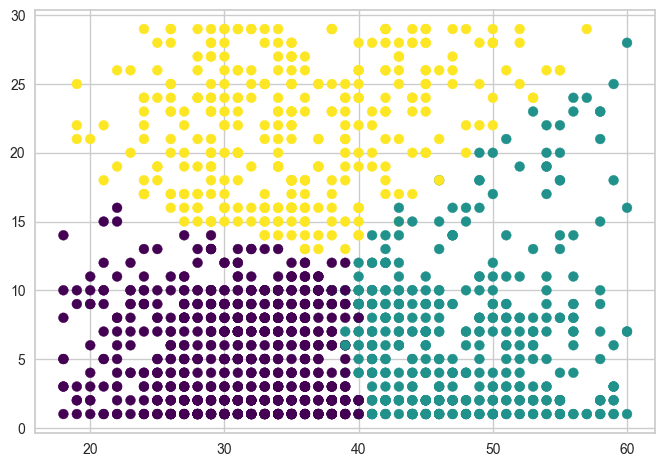

In [ ]:
# Plot the points with color code of the predicted clusters
# viridis - a color map, https://matplotlib.org/users/colormaps.html
# s - marker size, here, the dots size
# c - marker color, here taken from the predicted clusters
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='viridis')

plt.grid(True)
plt.show()

### Validating model

In [ ]:
KMmodel.predict(X)

score = silhouette_score(X, KMmodel.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.329


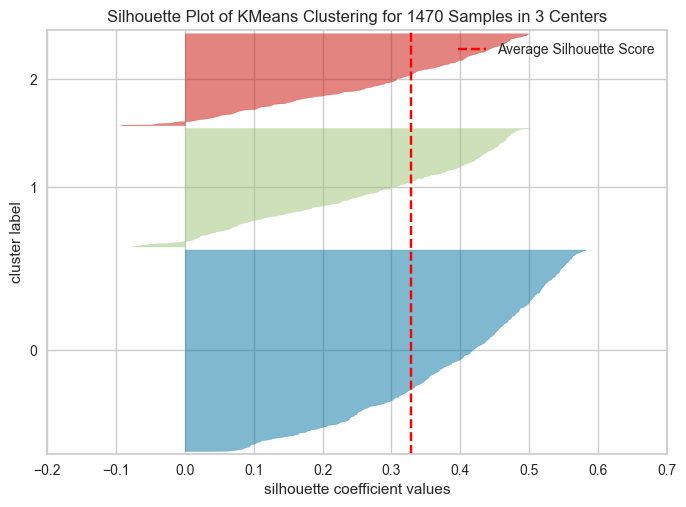

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1470 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Visualize the silhouette scores of all points
visualizer = SilhouetteVisualizer(KMmodel, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()  

The result of the clustering seems to be pretty bad, which would indicate that the data is not very well suited for clustering, or that the data has lost important information for clustering.